<a href="https://colab.research.google.com/github/iotanalytics/IoTTutorial/blob/main/code/clustering_and_classification/Kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##K-Means Clustering [Unsupervised]

*Author: Soumya Pal*

*Updated: Stephen Coshatt*

<br/>

**References:**

1.   https://towardsdatascience.com/how-does-k-means-clustering-in-machine-learning-work-fdaaaf5acfa0
2.   https://tslearn.readthedocs.io/en/stable/gen_modules/clustering/tslearn.clustering.TimeSeriesKMeans.html#tslearn.clustering.TimeSeriesKMeans



k-means algorithm is an iterative algorithm that tries to partition the dataset into K pre-defined distinct non-overlapping subgroups (clusters) where each data point belongs to only one group. It tries to make the intra-cluster data points as similar as possible while also keeping the clusters as different (far) as possible. It assigns data points to a cluster such that the sum of the squared distance between the data points and the cluster’s centroid (arithmetic mean of all the data points that belong to that cluster) is at the minimum. 

### K-Means Pseudo Code
Assign initial values for each u (from *u=1* till *u=k*);</br>
Repeat {
*   Assign each point in the input data to the *u* that is closest to it in value;
*   Calculate the new mean for each *u*;
*   if all *u* values are unchanged { break out of loop; }</br>
}

The algorithm starts by placing k different averages (i.e. means) whose values are either initialized randomly or set to real data points on the plane [1].  Next, the algorithm goes through the data points one-by-one, measuring the distance between each point and the centroids. The algorithm then groups the the data point with the closest centroid (i.e. closest in distance) [1].  This grouping forms the clusters.
</br>
</br>
#### Pros:
*   Simple: It is easy to implement k-means and identify unknown groups of data from complex data sets.
*   Flexible: K-means algorithm can easily adjust to the changes. If there are any problems, adjusting the cluster segment will allow changes to easily occur on the algorithm.
*   Suitable in a large dataset: K-means is suitable for a large number of datasets and it’s computed much faster than the smaller dataset.
*   Efficient: The algorithm used is good at segmenting the large data set. Its efficiency depends on the shape of the clusters. K-means work well in hyper-spherical clusters.
*   Easy to interpret: The results are easy to interpret. It generates cluster descriptions in a form minimized to ease understanding of the data.

#### Cons:
*   No-optimal set of clusters: K-means doesn’t allow development of an optimal set of clusters and for effective results, clusters has to be decided beforehand.
*   Handle numerical data: K-means algorithm can be performed on numerical data only.
*   Lacks consistency: K-means clustering gives varying results on different runs of an algorithm. A random choice of cluster patterns yields different clustering results resulting in inconsistency.
*   Sensitivity to scale: Changing or rescaling the dataset either through normalization or standardization will completely change the final results.

In [4]:
!pip install influxdb

In [3]:
!python -m pip install tslearn

     |████████████████████████████████| 793 kB 7.7 MB/s 


/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


maximum level is 10
maximum level is 10
(100, 240)
433.551 --> 228.709 --> 226.468 --> 225.887 --> 225.726 --> 225.565 --> 225.565 --> 


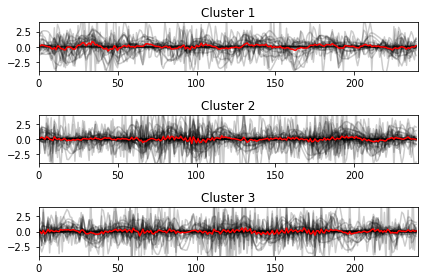

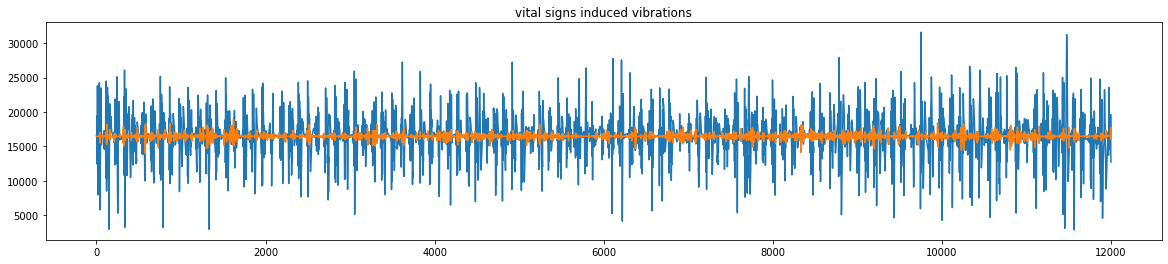

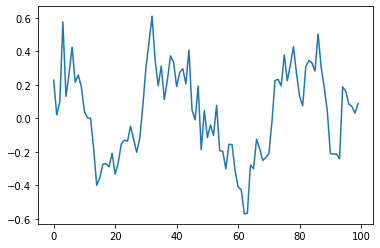

In [7]:
#__author__ = 'Ming'
#ming.song.cn@outlook.com
#originally from http://www1.cs.columbia.edu/~jopa/Papers/PaparrizosSIGMOD2015.pdf
#modified by stephen.coshatt@uga.edu to use k-means instead of k-shape

import numpy as np
import csv
import matplotlib.pyplot as plt
import pywt
from influxdb import InfluxDBClient
import operator
import scipy.signal as sg
import scipy as sp
# from dic.stl_decon import decomposing
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

def wdenoise(data, method, threshold):
    # Create wavelet object and define parameters
    w = pywt.Wavelet(method)
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    # maxlev = 2 # Override if desired
    print("maximum level is " + str(maxlev))
    # Decompose into wavelet components, to the level selected:
    coeffs = pywt.wavedec(data, method, level=maxlev)
    #cA = 0.0
    #cA = pywt.threshold(cA, threshold*max(cA))
    # plt.figure()
    for i in range(1, len(coeffs)):
        # plt.subplot(maxlev, 1, i)
        # plt.plot(coeffs[i])
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        # plt.plot(coeffs[i])
    datarec = pywt.waverec(coeffs, method)
    return datarec

ip = "sensorweb.us"

# unit = "b8:27:eb:a1:89:49"
unit1 = "b8:27:eb:f3:41:db" #shake1 cuhk
unit2 = "b8:27:eb:ed:53:36" #shake2 cuhk
# the other one: b8:27:eb:63:da:62


stampIni = "2020-08-22T20:00:00.000Z" # UTC time = EST time + 4
stampEnd = "2020-08-22T20:02:00.000Z"

client = InfluxDBClient(ip, "8086", "test", "sensorweb", "shake", ssl=True)


# query1

query = 'SELECT "value" FROM Z WHERE ("location" = \''+unit1+'\') and time >= \''+stampIni+'\' and time <= \''+stampEnd+'\''
result = client.query(query)
points = list(result.get_points())
values = map(operator.itemgetter('value'), points)
times = map(operator.itemgetter('time'), points)

data1 = np.array(list(values))

# query2

query = 'SELECT "value" FROM Z WHERE ("location" = \''+unit2+'\') and time >= \''+stampIni+'\' and time <= \''+stampEnd+'\''
result = client.query(query)
points = list(result.get_points())
values = map(operator.itemgetter('value'), points)
times = map(operator.itemgetter('time'), points)

data2 = np.array(list(values))

fs = 100 # for vibration data



if(len(data1) == 0 or len(data2) == 0):

    print("No data in the chosen time range!")

    quit()



datarec1 = wdenoise(data1, 'sym4', 0.4)
datarec2 = wdenoise(data2, 'sym4', 0.4)

# decon = decomposing(datarec)
# exit()


#### time series kmeans

X_train1 = np.split(datarec1, 50, axis=0)
X_train2 = np.split(datarec2, 50, axis=0)
x_train = X_train1 + X_train2
print(np.asarray(x_train).shape)
# exit()


### kmeans
seed = 0
np.random.seed(seed)

np.random.shuffle(x_train)

# For this method to operate properly, prior scaling is required
x_train = TimeSeriesScalerMeanVariance().fit_transform(x_train)
sz = x_train.shape[1]

# kMeans clustering
ks = TimeSeriesKMeans(n_clusters=3, verbose=True, random_state=seed)
y_pred = ks.fit_predict(x_train)

plt.figure()
for yi in range(3):
    plt.subplot(3, 1, 1 + yi)
    for xx in x_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(ks.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.title("Cluster %d" % (yi + 1))

plt.tight_layout()
plt.show()
plt.figure(figsize=(20, 4))
plt.title("vital signs induced vibrations")

plt.plot(datarec1)
plt.plot(datarec2)
plt.show()

# plot the template
#tem = ks.cluster_centers_[0].ravel()[100:170]
tem = ks.cluster_centers_[0].ravel()[100:200]
plt.plot(tem)
plt.show()